In [1]:
import os 
import copy 
import time

import resnet as rnet

import torch
import torchvision
import torchvision.models as models 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import numpy as np

using device cuda:0


In [2]:
path = !pwd
path = path[0]
print(path)
mdl_savefile = path+"/models/resnet56_cumultrain_parameters.pickle"
mdl_loadfile = mdl_savefile

/home/r2/Documents/DD2424project


### ResNet-56 https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

In [3]:
def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight)
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Loading data

In [4]:
torchvision.datasets.CIFAR10(path,download=True)
f"""adding transform ToTensor(); transforms PIL-images to tensor-format used by PyTorch""" 
batchsize = 1024
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
cifar10_train = torchvision.datasets.CIFAR10(path, train=True, transform=transform)
cifar10_valid = torchvision.datasets.CIFAR10(path, train=False,transform=transform)
dataloader_tr = torch.utils.data.DataLoader(cifar10_train,
                                          batch_size=batchsize,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=True)
dataloader_vl = torch.utils.data.DataLoader(cifar10_valid,
                                          batch_size=batchsize,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=True)

Files already downloaded and verified


Functions


In [5]:
def show_model(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
    return torch.tensor(oneh_labels).long()
def get_xent_acc(prediction, labels):
    predicted_labels = np.argmax(prediction.cpu().data.numpy(),1)
    (predicted_labels - labels.cpu().data.numpy())
    return sum((predicted_labels - labels.cpu().data.numpy()) == 0)/predicted_labels.shape[0]
def xent_softmax(prediction):
    pred = np.exp(prediction.cpu().data.numpy())
    divide = np.repeat(pred.sum(1).reshape(pred.shape[0],1), pred.shape[1],1)
    pred = np.divide(pred,divide)
    return pred 
def get_valacc(valacc, valloss):
    with torch.no_grad():
        f"""certain layers have different properties during evaluation e.g dropout. 
            therefor we use resnet.eval()"""
        resnet.eval()      
        for i, (valimgs, vallabels) in enumerate(valid_data_loader):
            if cuda_available: 
                valimgs   = valimgs.cuda()
                vallabels = vallabels.cuda()
            valprediction = resnet.forward(valimgs)    
            valloss = valloss + [loss_xent(valprediction, vallabels)]
            valacc = valacc + [get_xent_acc(valprediction, vallabels)]
            break
        f"""reset resnet for training with resnet.train()"""
        resnet.train()
    return valacc, valloss

def update_results(n_vbatches=1):
    f"updates loss and accuracy for training and validation" 
    global accu_tr
    global accu_val
    global loss_tr
    global loss_val
    accu_tr  += [get_xent_acc(prediction, labels)]
    loss_tr  += [output.data.cpu().numpy().item()]
    with torch.no_grad():
        network.eval()      
        accu, loss = 0, 0
        for i, (imgs_val, labels_val) in enumerate(dataloader_vl):
            imgs_val, labels_val = cuda(imgs_val), cuda(labels_val)
            prediction_val = network.forward(imgs_val)  
            accu += get_xent_acc(prediction_val, labels_val)
            loss +=       lossfn(prediction_val, labels_val).data.cpu().numpy().item()
            if i == n_vbatches:
                break
        loss_val = loss_val + [loss/(i+1)]
        accu_val = accu_val + [accu/(i+1)]
        network.train()
        
        
def compare_parameters(net1, net2):
    f"""compare parameters of two models with the same architecture""" 
    net1_param, net2_param, diff = [], [], 0
    for param_tensor in net1.state_dict():
        net1_param = net1_param + [net1.state_dict()[param_tensor]]
        net2_param = net2_param + [net2.state_dict()[param_tensor]]
    for i in range(len(net1_param)):
        diff = diff + np.sum(net1_param[i].cpu().numpy() - net2_param[i].cpu().numpy())
    print(f"""difference in weights and biases is: {diff} between network1 and network2""")
    
def load_cifar10(bsize_tr,bsize_val=128):
    torchvision.datasets.CIFAR10(path,download=True)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    cifar10_train = torchvision.datasets.CIFAR10(path, train=True, transform=transform)
    cifar10_valid = torchvision.datasets.CIFAR10(path, train=False,transform=transform)
    dataloader_tr = torch.utils.data.DataLoader(cifar10_train,
                                              batch_size=bsize_tr,
                                              shuffle=True,
                                              num_workers=0,
                                              pin_memory=True)
    dataloader_val = torch.utils.data.DataLoader(cifar10_valid,
                                              batch_size=bsize_val,
                                              shuffle=False,
                                              num_workers=0,
                                              pin_memory=True)
    return dataloader_tr, dataloader_val

def cuda(thing):
    if torch.cuda.is_available(): return thing.cuda()        
    return thing

# Learning rate range test

In [6]:
def range_test(net,opt,dataloader,lossfn,max_lr,min_lr,iterations,batchsize):
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, min_lr, max_lr, 
                                                  step_size_up=iterations, step_size_down=iterations, 
                                                  mode='triangular', cycle_momentum=True,
                                                  base_momentum=0.8, max_momentum=0.95)
    accuracy  = []
    loss      = []
    datait    = iter(dataloader)
    n_batches = len(datait)
    interval  = 5
    batch     = 0
    for i in range(1,iterations):
        batch += 1
        if batch >= n_batches:
            datait = iter(dataloader)
            batch = 0 
        images, labels = datait.next() 
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
        prediction = net.forward(images)
        output     = lossfn(prediction, labels)
        f"""Use accuracy on training-set"""
        if i % interval == 0:
            accuracy   = accuracy + [get_xent_acc(prediction, labels)]
            loss       = loss + [output]
        opt.zero_grad()   # clear gradients from previous time-step 
        output.backward() # calculates gradients 
        opt.step()        # updates weights
        scheduler.step()  # change learning-rate in range_optimizer
    f"""make and save plot of accuracy"""
    x1, x2 = [np.linspace(min_lr, max_lr, num) for num in [len(accuracy), len(loss)]]
    
    plt.plot(x1, np.array(accuracy))
    save_file = path+f"""/rangetest/acc_bs{batchsize}_minlr{min_lr}_maxlr{max_lr}_iterations{iterations}.png"""
    plt.savefig(save_file)
    plt.show()
    
    return accuracy, loss

In [7]:
%%capture
resnet = ResNet(BasicBlock,[9,9,9])
if cuda_available: resnet.cuda()

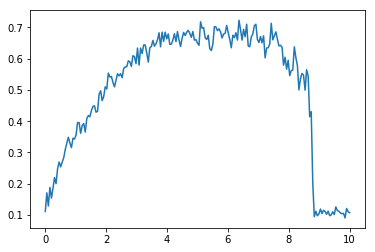

In [71]:
max_lr = 10
min_lr = 0.0001
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=1e-4)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

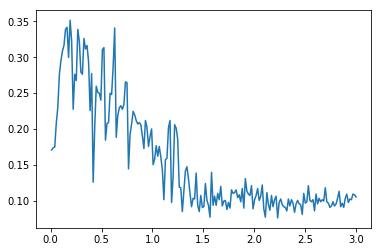

In [88]:
max_lr = 3
min_lr = 0.01
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=1e-2)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

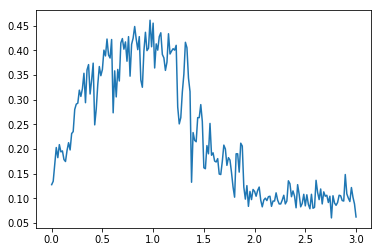

In [96]:
max_lr = 3
min_lr = 0.0001
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay= 3.2*1e-3)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

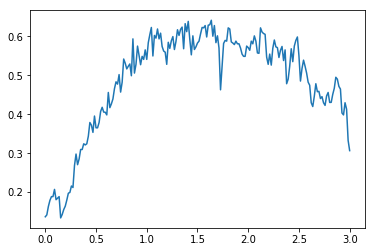

In [104]:
max_lr = 3
min_lr = 0.0001
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=1e-3)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

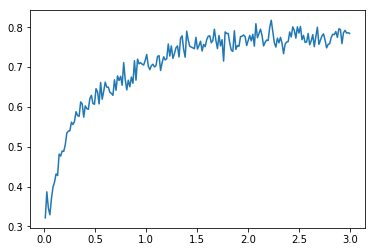

In [106]:
max_lr = 3
min_lr = 0.01
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=1e-4)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

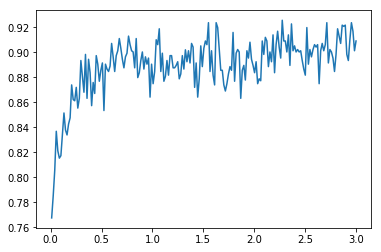

In [108]:
max_lr = 3
min_lr = 0.01
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=1e-5)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

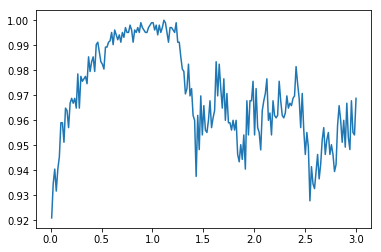

In [110]:
max_lr = 3
min_lr = 0.01
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=1e-6)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

# Setting the Momentum and Weight Decay to zero 

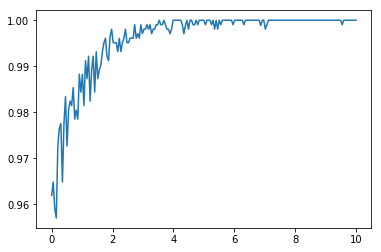

In [112]:
max_lr = 10
min_lr = 0.0001
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0, weight_decay=0)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

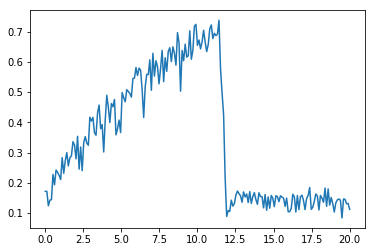

In [120]:
max_lr = 20
min_lr = 0.01
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0, weight_decay=0)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

In [33]:
max_lr = 3
min_lr = 0.01
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0, weight_decay=0)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)
plt.xlabel("Learning rate")
plt.ylabel("Validation accuracy")

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 11.92 GiB total capacity; 7.51 GiB already allocated; 4.75 MiB free; 1.80 MiB cached)

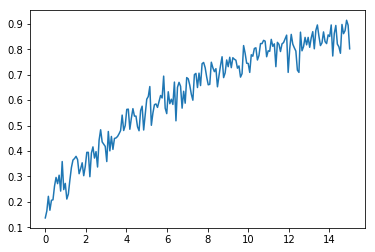

In [138]:
max_lr = 15
min_lr = 0.0001
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0, weight_decay=0)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

# From above results, let max_lr=10 , add variable momentum and constant weight decay now 

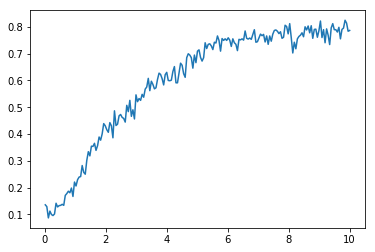

In [158]:
max_lr = 10
min_lr = 0.01
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=0)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

In [ ]:
lr_max   = 10.0
lr_min   = 0.01
bsize_tr = 1024
step_it  = 150
mom_min  = 0.8
n_cycles   = 2


start = time.time()
dataloader_tr, dataloader_vl = load_cifar10(bsize_tr) 
lossfn      = nn.CrossEntropyLoss()
results_momentum = []
intvl_val  = 10
intvl_time = 100
momentums_max = [0.9, 0.95, 0.97, 0.99]
for mom_max in momentums_max:    
    accu_tr, accu_val, loss_tr, loss_val = [], [], [], []
    network   = rnet.resnet56()
    if cuda_available: network.cuda()
    optimizer = optim.SGD(network.parameters(), lr=lr_min)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              lr_min, 
                                              lr_max, 
                                              step_size_up=step_it, 
                                              step_size_down=step_it, 
                                              mode='triangular', 
                                              cycle_momentum=True, 
                                              base_momentum=mom_min,
                                              max_momentum=mom_max)
    f"do short run"
    for cycle in range(1,n_cycles+1):
        i = 1
        while i <= step_it*2:
            datait_tr = iter(dataloader_tr)
            for n, (images, labels) in enumerate(datait_tr):
                images, labels = cuda(images), cuda(labels)
                prediction     = network.forward(images)
                output         = lossfn(prediction, labels)
                if i % intvl_val  == 0: update_results(n_vbatches=10)                 
                optimizer.zero_grad()  # clear old gradients
                output.backward()      # calculate new gradients 
                optimizer.step()       # updates weights
                scheduler.step()       # change learning-rate in optimizer
                if i % intvl_time == 0: print(f"time after cycle {cycle} and {i} iterations: {time.time() - start} seconds")                
                i += 1                    
                if i > step_it*2: break

    f"deepcopy results and make room for another run"
    results_momentum.append({'mom_max' :mom_max,
                             'accu_tr' :copy.deepcopy(np.array(accu_tr)), 
                             'accu_val':copy.deepcopy(np.array(accu_val)), 
                             'loss_tr' :copy.deepcopy(np.array(loss_tr)), 
                             'loss_val':copy.deepcopy(np.array(loss_val))})
print(f"complete\n the whole process took: {(time.time() - start)/60.0} minutes")


Files already downloaded and verified
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
Batch

/home/r2/Documents/DD2424project/resnet.py:37: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


time after cycle 1 and 100 iterations: 60.81549859046936 seconds
time after cycle 1 and 200 iterations: 132.09165930747986 seconds
time after cycle 1 and 300 iterations: 185.36528301239014 seconds
time after cycle 2 and 100 iterations: 255.74328303337097 seconds
time after cycle 2 and 200 iterations: 303.01072454452515 seconds
time after cycle 2 and 300 iterations: 369.02019739151 seconds
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d


# lr_max   = 1.0              lr_min   = lr_max/10.0             bsize_tr = 512

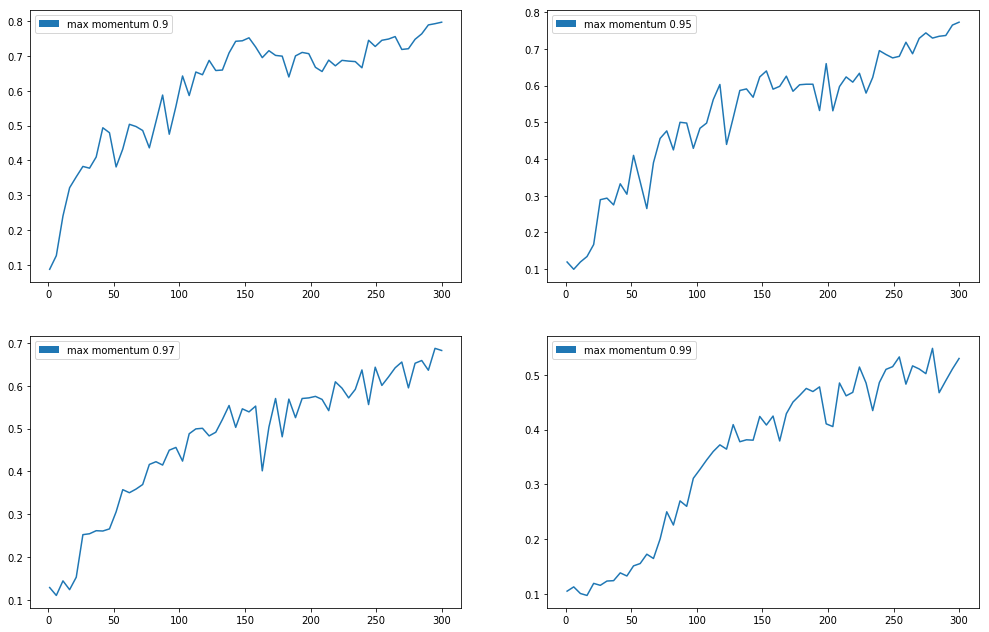

In [15]:
import matplotlib.patches as mpatches

plt.figure(figsize=(17,17))
for i, result in enumerate(results_momentum):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"max momentum {result['mom_max']} "
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

# lr_max   = 3.0  lr_min   = 0.03  bsize_tr = 1024

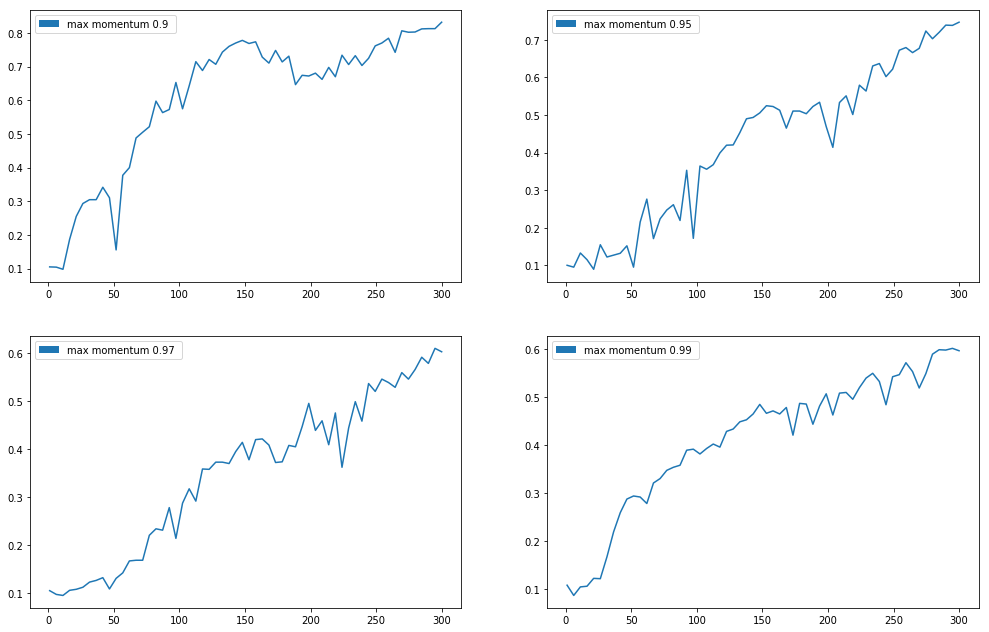

In [27]:
import matplotlib.patches as mpatches

plt.figure(figsize=(17,17))
for i, result in enumerate(results_momentum):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"max momentum {result['mom_max']} "
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

# lr_max   = 3.0  lr_min   = 0.001  bsize_tr = 1024

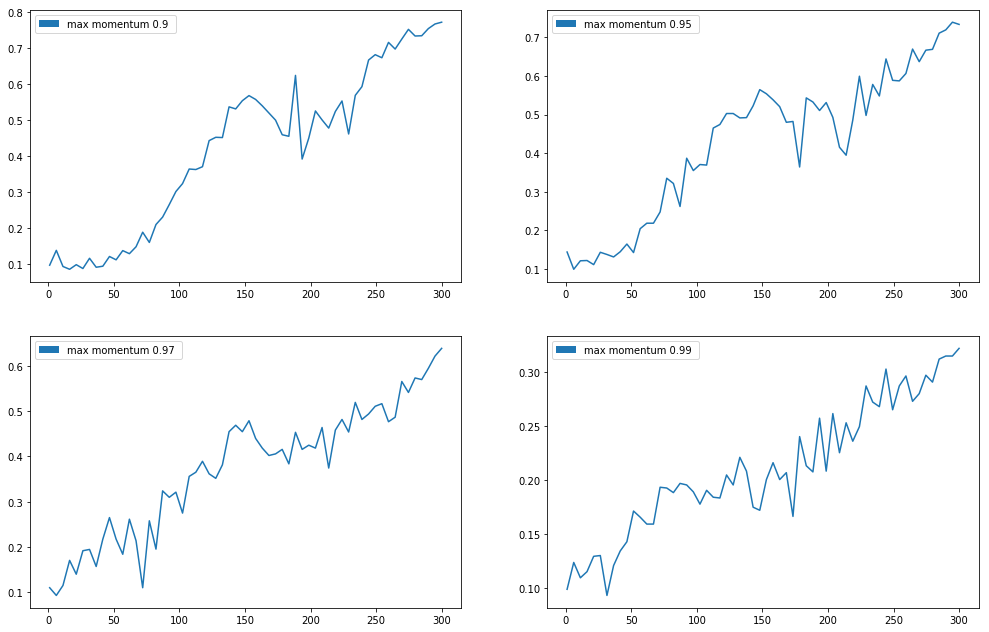

In [43]:
import matplotlib.patches as mpatches

plt.figure(figsize=(17,17))
for i, result in enumerate(results_momentum):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"max momentum {result['mom_max']} "
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

# lr_max   = 3.0  lr_min   = 0.3   bsize_tr = 1024

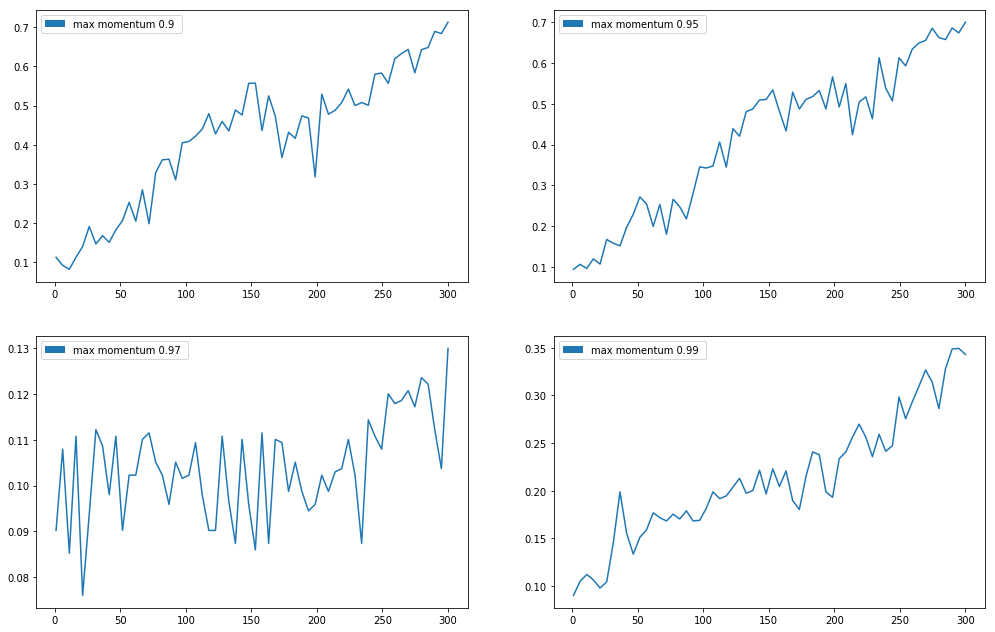

In [54]:
import matplotlib.patches as mpatches

plt.figure(figsize=(17,17))
for i, result in enumerate(results_momentum):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"max momentum {result['mom_max']} "
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

# lr_max   = 10.0  lr_min   = 0.01  bsize_tr = 512

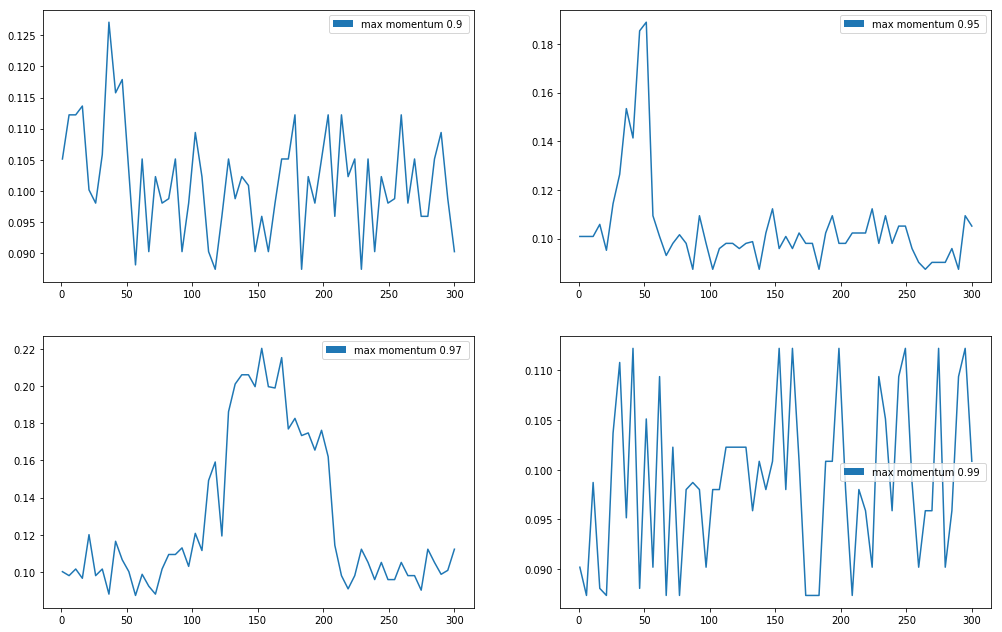

In [65]:
import matplotlib.patches as mpatches

plt.figure(figsize=(17,17))
for i, result in enumerate(results_momentum):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"max momentum {result['mom_max']} "
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

lr_max = 10.0 lr_min = 0.01 bsize_tr = 1024

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(17,17))
for i, result in enumerate(results_momentum):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"max momentum {result['mom_max']} "
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

In [81]:
 lr_max   = 3.0
 lr_min   = lr_max/10.0
 bsize_tr = 1024
 mom_max  = 0.9
 mom_min  = 0.8
 step_epo = 5
 step_it  = 50000/bsize_tr*step_epo
 anne_epo = 2 
 anne_it  = 50000/bsize_tr*anne_epo
 cycles   = 1

In [82]:
dataloader_tr, dataloader_vl = load_cifar10(bsize_tr)
lossfn      = nn.CrossEntropyLoss()
results_weightdecay = [] 
intvl_val  = 10
intvl_time = 10
for j, wd in enumerate([1e-4, 1e-5, 1e-6]):
    accu_tr, accu_val, loss_tr, loss_val = [], [], [], []
    network   = rnet.resnet56()
    if cuda_available: network.cuda()
    optimizer = optim.SGD(network.parameters(), lr= lr_min)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  lr_min, 
                                                  lr_max, 
                                                  step_size_up=step_it, 
                                                  step_size_down=step_it, 
                                                  mode='triangular', 
                                                  cycle_momentum=True, 
                                                  base_momentum=mom_min,
                                                  max_momentum=mom_max)
    f"do Cyclic Learning-Rate training"
    for cycle in range(1,cycles):
        i = 1
        while i < step_it*2:
            datait_tr = iter(dataloader_tr)
            for n, (images, labels) in enumerate(datait_tr):
                images, labels = cuda(images), cuda(labels)
                prediction     = network.forward(images)
                output         = lossfn(prediction, labels)
                if i % intvl_val  == 0: update_results(n_vbatches=10)                 
                optimizer.zero_grad()  # clear old gradients
                output.backward()      # calculate new gradients 
                optimizer.step()       # updates weights
                scheduler.step()       # change learning-rate in optimizer
                if i % intvl_time == 0: print(f"time after {i} iterations: {time.time() - start} seconds")                
                i += 1                    
                
                if i >= step_it*2   : break
    f"do annealing"
    
    f"deepcopy results and make room for another run"
    print(f"weight decay values found are: {result['wd']} ")
    results_weightdecay.append({'wd'      :wd,
                                'accu_tr' :copy.deepcopy(np.array(accu_tr)), 
                                'accu_val':copy.deepcopy(np.array(accu_val)), 
                                'loss_tr' :copy.deepcopy(np.array(loss_tr)), 
                                'loss_val':copy.deepcopy(np.array(loss_val))})
  

Files already downloaded and verified
weight decay values found are: 1e-06 
weight decay values found are: 1e-06 
weight decay values found are: 1e-06 


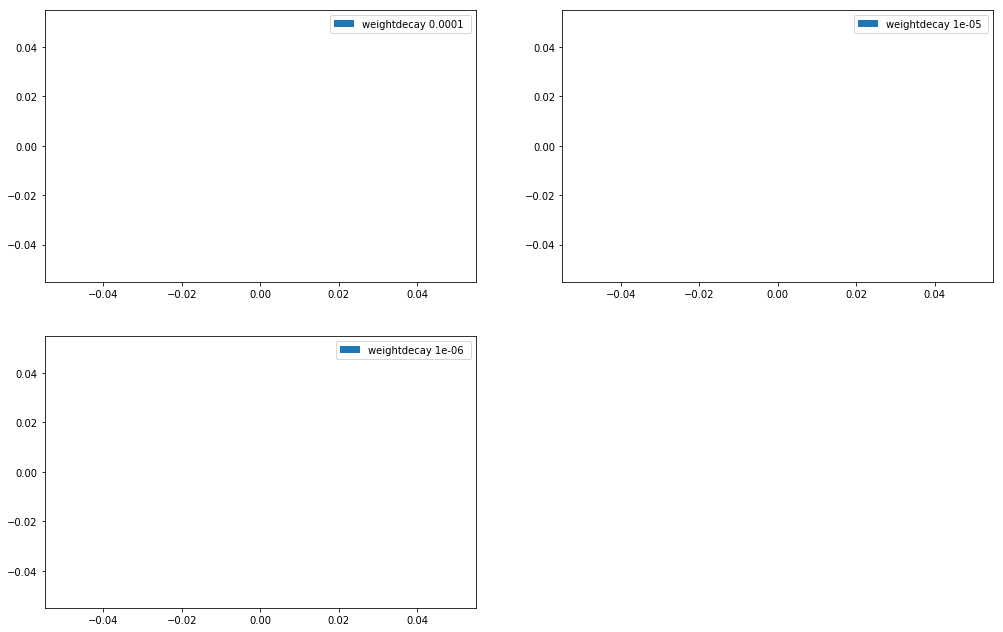

In [68]:
import matplotlib.patches as mpatches

plt.figure(figsize=(17,17))
for i, result in enumerate(results_weightdecay):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"weightdecay {result['wd']} "
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])